<a href="https://colab.research.google.com/github/1900690/analog-meter-reading/blob/main/analog_meter_reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##課題
*   ハフ変換のみでは二つの線の交点が現れないことがある
*   影によるノイズの影響が大きい
*   針がどちらを向いているのかわからない場合が多い



##解決方法


*   検出するのは一番長い線のみとする
*   検出する線は画像の中心点から伸びているもののみとする



In [41]:
#@title 分析する画像をアップロードまたはサンプル画像で分析

#事前準備
from google.colab import files
import os
サンプル画像を使用する = True # @param {type:"boolean"}
#@markdown ※サンプル画像は、分析ごとに５つの画像の中からランダムで１つ選ばれるようになっています。
if サンプル画像を使用する == True:
  if os.path.exists('/content/test-meter.jpg'):
     os.remove('/content/test-meter.jpg')
  !wget -q  https://github.com/1900690/analog-meter-reading/releases/download/sample/test-meter-images.zip
  !unzip -q test-meter-images.zip

else:
  uploaded_file = files.upload()
  uploaded_file_name = next(iter(uploaded_file))

角度は 290.9999996737618


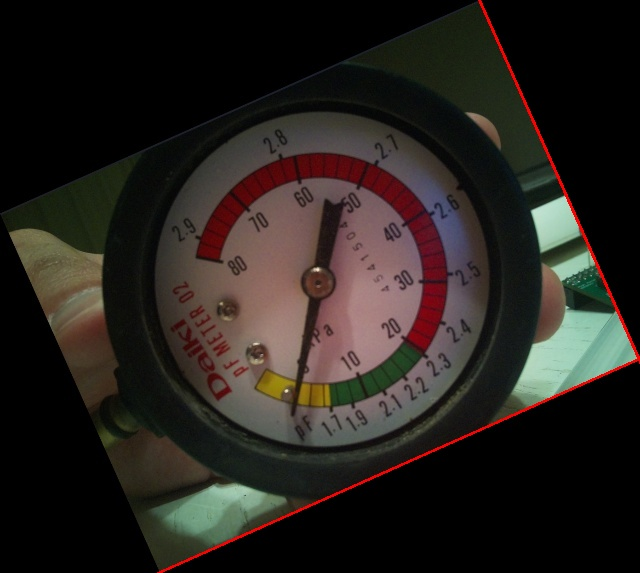

In [54]:
#@title 分析方法①
#@markdown ※角度は真下から左回転の角度
# cv2.HoughLines() 関数
import cv2
import numpy as np
import statistics
from google.colab.patches import cv2_imshow
import os
import random

if サンプル画像を使用する == True:
  folder_path = '/content/test-meter-images'
  files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
  random_file = random.choice(files)
  img = cv2.imread(random_file)
else:
  img = cv2.imread(uploaded_file_name)

# 画像の大きさを取得
height, width, channels = img.shape[:3]

# 二値化
threshold = 100
ret,img_thresh = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)

# エッジ画像へ変換(ハフ変換で直線を求めるため)
edges = cv2.Canny(img_thresh,50,200,apertureSize = 3)
cv2.imwrite('houghlines2.jpg',edges)
cv2.imwrite('houghlines1.jpg',img_thresh)
# 自動的に直線が2本となるパラメータを検出
# minn：何点の点が並んでいたら、直線を引くか？のパラメーター値

for m in range(10,161,1):
    lines = cv2.HoughLines(edges,1,np.pi/180,m)
    if lines is None:
        break
    #print(len(lines))
    if len(lines)==2:
        minn = m
#print('minn = ', minn)

lines = cv2.HoughLines(edges,1,np.pi/180,minn)

theta_t = [] # 原点から直線に向かって下した法線と、水平線との角度 (ラジアン) を格納する配列
aa = []   # 直線の傾きを格納する配列
bb = []   # 直線の切片を格納する配列

i = 0
for i in range(len(lines)):
   for rho,theta in lines[i]:
        #print('rho = ', rho)
        #print('theta = ', theta)
        theta_t.append(theta)
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
        # 2点を通る直線の式は、y = (y2-y1)/(x2-x1)x - (y2-y1)/(x2-x1)x1 + y1
        # 傾き a = (y2-y1)/(x2-x1) 、 b = y1 - (y2-y1)/(x2-x1)x1
        a0 = (y2 - y1) / (x2 - x1)
        b0 = y1 - (y2 - y1) / (x2 - x1)* x1

        aa.append(a0)
        bb.append(b0)
# 針が画像の左上、左下、右上、右下 のどこにいるかを、2直線の交点の位置で判断し、角度の式を変更
# なお、針の中心は画像の中心にあるとして、計算
# 交点の式は、((b[1] - b[0]) / (a[0] - a[1]) , (a[0] * b[1] - b[0] * a[1]) / (a[0] - a[1]) )

x_t = (bb[1] - bb[0]) / (aa[0] - aa[1])
y_t = (aa[0] * bb[1] - bb[0] * aa[1]) / (aa[0] - aa[1])

if x_t < width/2: # 針が左上か左下にいるとき
    theta_hor = statistics.mean(theta_t)*180/np.pi
else: # 針が右上か右下にいるとき
    theta_hor = 270 - (90 - statistics.mean(theta_t)*180/np.pi)
print('角度は',theta_hor)

cv2.imwrite('/content/meter_line.jpg',img)
img_show = cv2.imread('/content/meter_line.jpg')
cv2_imshow(img_show)

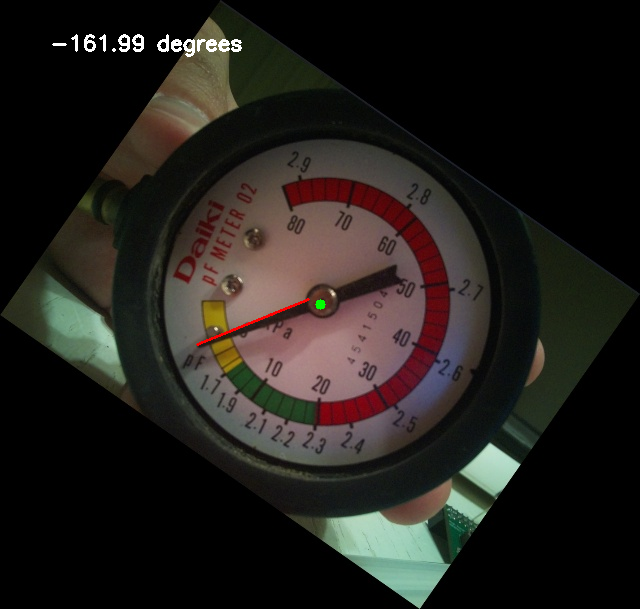

In [59]:
#@title 分析方法②

#@markdown ※角度はx軸から左回りに計測したもの
import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow

# 画像の読み込み
if サンプル画像を使用する == True:
  folder_path = '/content/test-meter-images'
  files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
  random_file = random.choice(files)
  img = cv2.imread(random_file)
else:
  img = cv2.imread(uploaded_file_name)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# エッジ検出
edges = cv2.Canny(gray, 50, 150)

# ハフ変換による直線検出
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)

# メーターの中心を推定
center = (img.shape[1] // 2, img.shape[0] // 2)

# 針と考えられる最長の線を見つける
longest_line = None
max_length = 0
angle = None

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        # メーターの中心に最も近い点を始点として考える
        if math.sqrt((x1 - center[0]) ** 2 + (y1 - center[1]) ** 2) < math.sqrt((x2 - center[0]) ** 2 + (y2 - center[1]) ** 2):
            start_x, start_y, end_x, end_y = x1, y1, x2, y2
        else:
            start_x, start_y, end_x, end_y = x2, y2, x1, y1

        # メーターの中心からの線のみを考慮
        if length > max_length and math.sqrt((start_x - center[0]) ** 2 + (start_y - center[1]) ** 2) < 50:
            max_length = length
            longest_line = (start_x, start_y, end_x, end_y)
            angle = math.degrees(math.atan2(center[1] - end_y, end_x - center[0]))

# 針を描画
if longest_line:
    start_x, start_y, end_x, end_y = longest_line
    cv2.line(img, (start_x, start_y), (end_x, end_y), (0, 0, 255), 2)
    cv2.circle(img, center, 5, (0, 255, 0), -1)
    if angle is not None:
        cv2.putText(img, f"{angle:.2f} degrees", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# 結果の表示
cv2_imshow(img)

##参考文献

1.   [アナログメーターの画像から針の角度を読み取るやつ作ってみた(OpenCV)](https://arkouji.cocolog-nifty.com/blog/2021/09/post-2c82af.html)
2.   [「メーター解析処理」の実装](https://www.primecast.co.jp/columns/8ieb_pgnqe)

